In [1]:
%cd ..
import glob
import sys
from dmg.realism.mle import whichFitsBetter
from scripts.modelSet import datasets_supported
msetObject = datasets_supported['yakindu-exercise']
train_path = 'data/yakindu-exercise/train'
backend = 'python'
hidden_dim = 64
model_path = 'models/yakindu-exercise-finalModel.m'

/home/antolin/wakame/DMG-Python


# Load dataset

In [2]:
graphs = [msetObject.getGraphReal(f,backend) 
                for f in glob.glob(train_path + "/*")]

In [3]:
print('Number of graphs:', len(graphs))

Number of graphs: 164


# Nodes and sequence

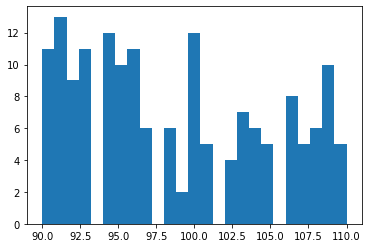

In [4]:
import matplotlib.pyplot as plt

h = plt.hist([len(G) for G in graphs], bins = 25)

# Sample from the generator

In [5]:
from dmg.deeplearning.generativeModel import GenerativeModel
from dmg.deeplearning.generativeModel import sampleGraph
from networkx.algorithms.isomorphism import is_isomorphic
import dmg.graphUtils as gu
import torch


model = GenerativeModel(hidden_dim, msetObject.dic_nodes, 
                        msetObject.dic_edges, 
                        msetObject.operations)
checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GenerativeModel(
  (emb_nodes): Embedding(9, 64)
  (emb_actions): Embedding(8, 64)
  (convolution): Sequential(
    (0): RGCNConv(64, 64, num_relations=8)
    (1): ReLU(inplace=True)
    (2): RGCNConv(64, 64, num_relations=8)
    (3): ReLU(inplace=True)
  )
  (gru): GRU(64, 64, batch_first=True)
  (linAction): Linear(in_features=64, out_features=64, bias=True)
  (linAction_final): Linear(in_features=64, out_features=8, bias=True)
  (linNodes): Linear(in_features=128, out_features=64, bias=True)
  (linNodes_final): Linear(in_features=64, out_features=1, bias=True)
  (finishedLin): Linear(in_features=64, out_features=64, bias=True)
  (finishedFinal): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
import random
import numpy as np
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)

In [7]:
from tqdm.notebook import tqdm

number_models = 500
max_size = 150
samples = [sampleGraph(msetObject.pallete.initialGraphs[0], 
                           msetObject.pallete, model, 
                           max_size, msetObject.pallete.separator) 
           for i in tqdm(range(number_models), desc='[NM]')]

[NM]:   0%|          | 0/500 [00:00<?, ?it/s]

/home/antolin/wakame/DMG-Python/dmg/deeplearning/generativeModel.py:206: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m = Categorical(F.softmax(torch.squeeze(action)))
/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
from dmg.yakindu.yakinduConsistency import (noEntryRegion, multipleEntryRegion, 
                                            incomingToEntry, noStateRegion, choice, exitFinal, entryOutTran)

dic = {0 : noEntryRegion,
      1 : multipleEntryRegion,
      2: incomingToEntry,
      3: noStateRegion,
      4: choice,
      5: exitFinal,
      6: entryOutTran}
dic_count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

for s in samples:
    for k,inc in dic.items():
        if inc(s):
            dic_count[k] += 1

In [10]:
dic_count

{0: 26, 1: 82, 2: 0, 3: 5, 4: 115, 5: 21, 6: 12}

In [ ]:
inconsistents = []
for s in samples:
    if msetObject.inconsistency(s):
        inconsistents.append(s)
inco_prop = len(inconsistents)*100/len(samples)
not_inconsistents = [g for g in samples if not g in inconsistents]

In [ ]:
inco_prop

In [ ]:
iso = []
for s in samples:
    for g in graphs:
        if (is_isomorphic(s,g,gu.node_match_type, gu.edge_match_type)):
            iso.append(s)
            break
iso_prop = len(iso)*100/len(samples)

In [ ]:
iso_prop

In [ ]:
clean_new_models = [g for g in samples if (not g in inconsistents) and (not g in iso)]
clean_pr = len(clean_new_models)*100/len(samples)
clean_pr

In [ ]:
dot = gu.plotGraphViz(random.sample(clean_new_models,1)[0])
dot

In [ ]:
!pwd

In [ ]:
dot.render(filename='examples/yakindu-github-3')